In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.model_selection import train_test_split

In [200]:
# Stratified sampling
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"]<5, 5.0, inplace=True)

housing["income_cat"].value_counts() / len(housing)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [207]:
# Build a data pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelBinarizer


num_attribs = list(housing)
num_attribs.remove('ocean_proximity')

cat_attribs = ['ocean_proximity']


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values


rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, population_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombineAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])

In [209]:
housing_prepared = full_pipeline.fit_transform(strat_train_set)

In [211]:
housing_prepared.shape

(16512, 22)

In [181]:
# Take care of missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

_strat_train_set_num = strat_train_set.drop("ocean_proximity", axis=1)
imputer.fit(_strat_train_set_num)
imputer.statistics_

X = imputer.transform(_strat_train_set_num)

In [186]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = strat_train_set['ocean_proximity']

housing_cat_encoded = encoder.fit_transform(housing_cat)

housing_cat_encoded

print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [188]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [177]:
# Separate the predictors from labels
housing_pred = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [153]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20433 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
ocean_proximity             20640 non-null object
rooms_per_household         20640 non-null float64
bedrooms_per_room           20433 non-null float64
bedrooms_per_household      20433 non-null float64
population_per_household    20640 non-null float64
dtypes: float64(13), object(1)
memory usage: 2.2+ MB


In [65]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


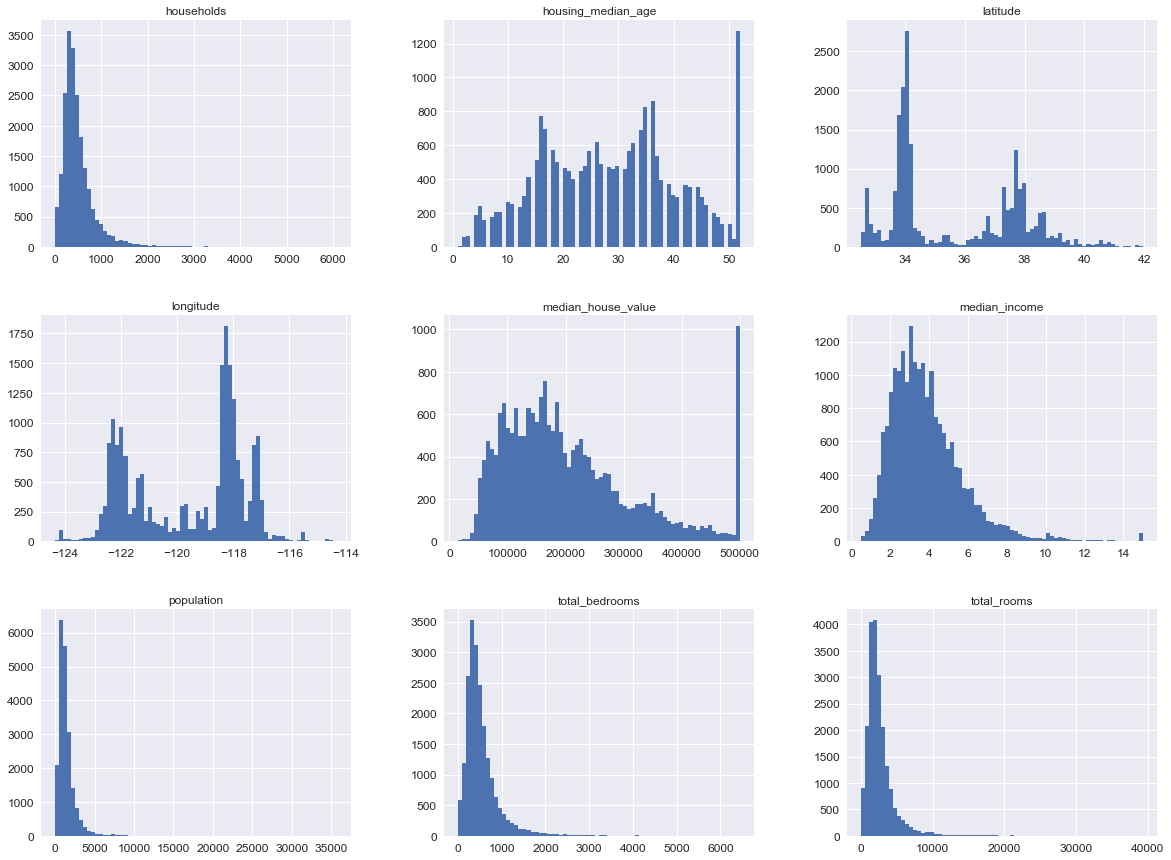

In [66]:
housing.hist(bins=70, figsize=(20, 15));

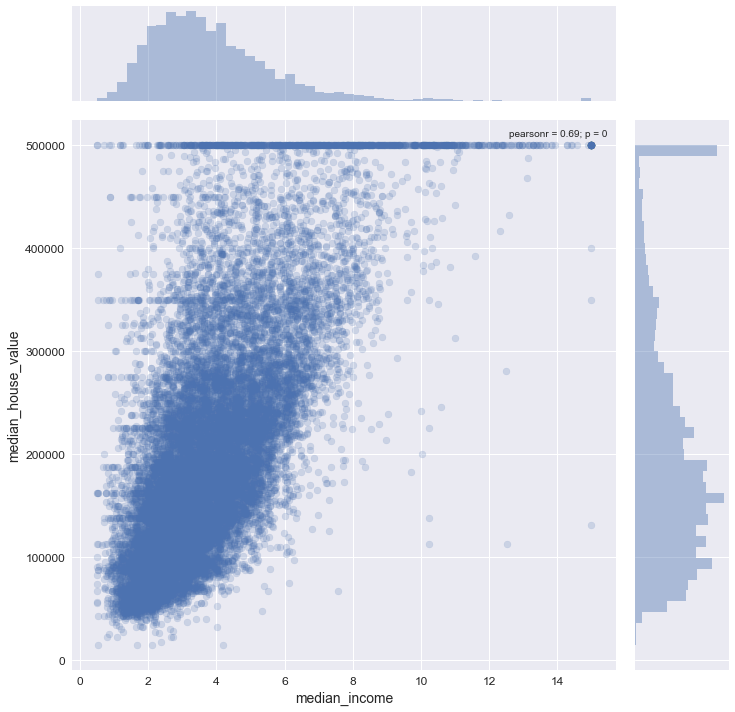

In [145]:
sns.jointplot(y="median_house_value", x="median_income", data=housing, size=10, alpha=0.2);

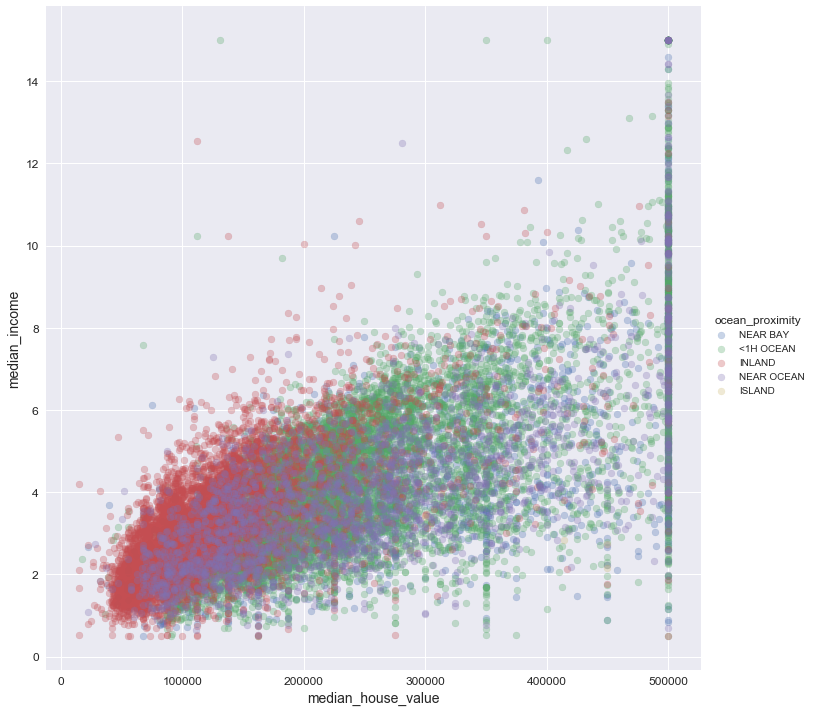

In [ ]:
sns.FacetGrid(housing, hue="ocean_proximity", size=10)\
.map(plt.scatter, "median_house_value", "median_income", alpha=0.3)\
.add_legend();

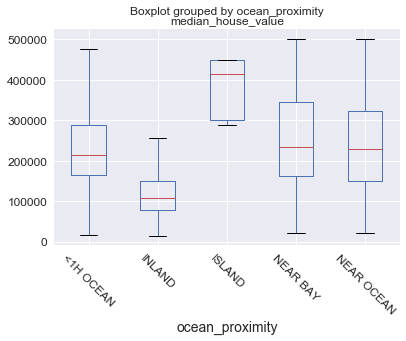

In [98]:
housing.boxplot(column='median_house_value', by='ocean_proximity', rot=-45);

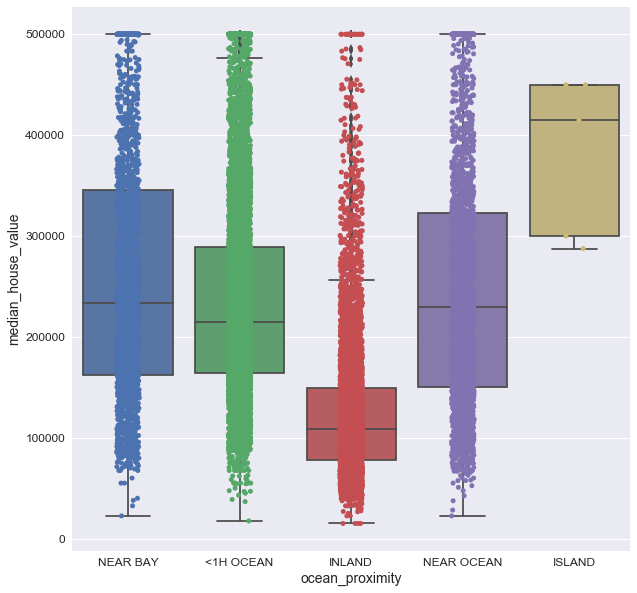

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(y="median_house_value", x='ocean_proximity',  data=housing, orient='v', ax=ax);
sns.stripplot(x="ocean_proximity", y="median_house_value", data=housing, jitter=True, edgecolor="gray", ax=ax)

/Users/zy/workspace/sklearn/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/zy/workspace/sklearn/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


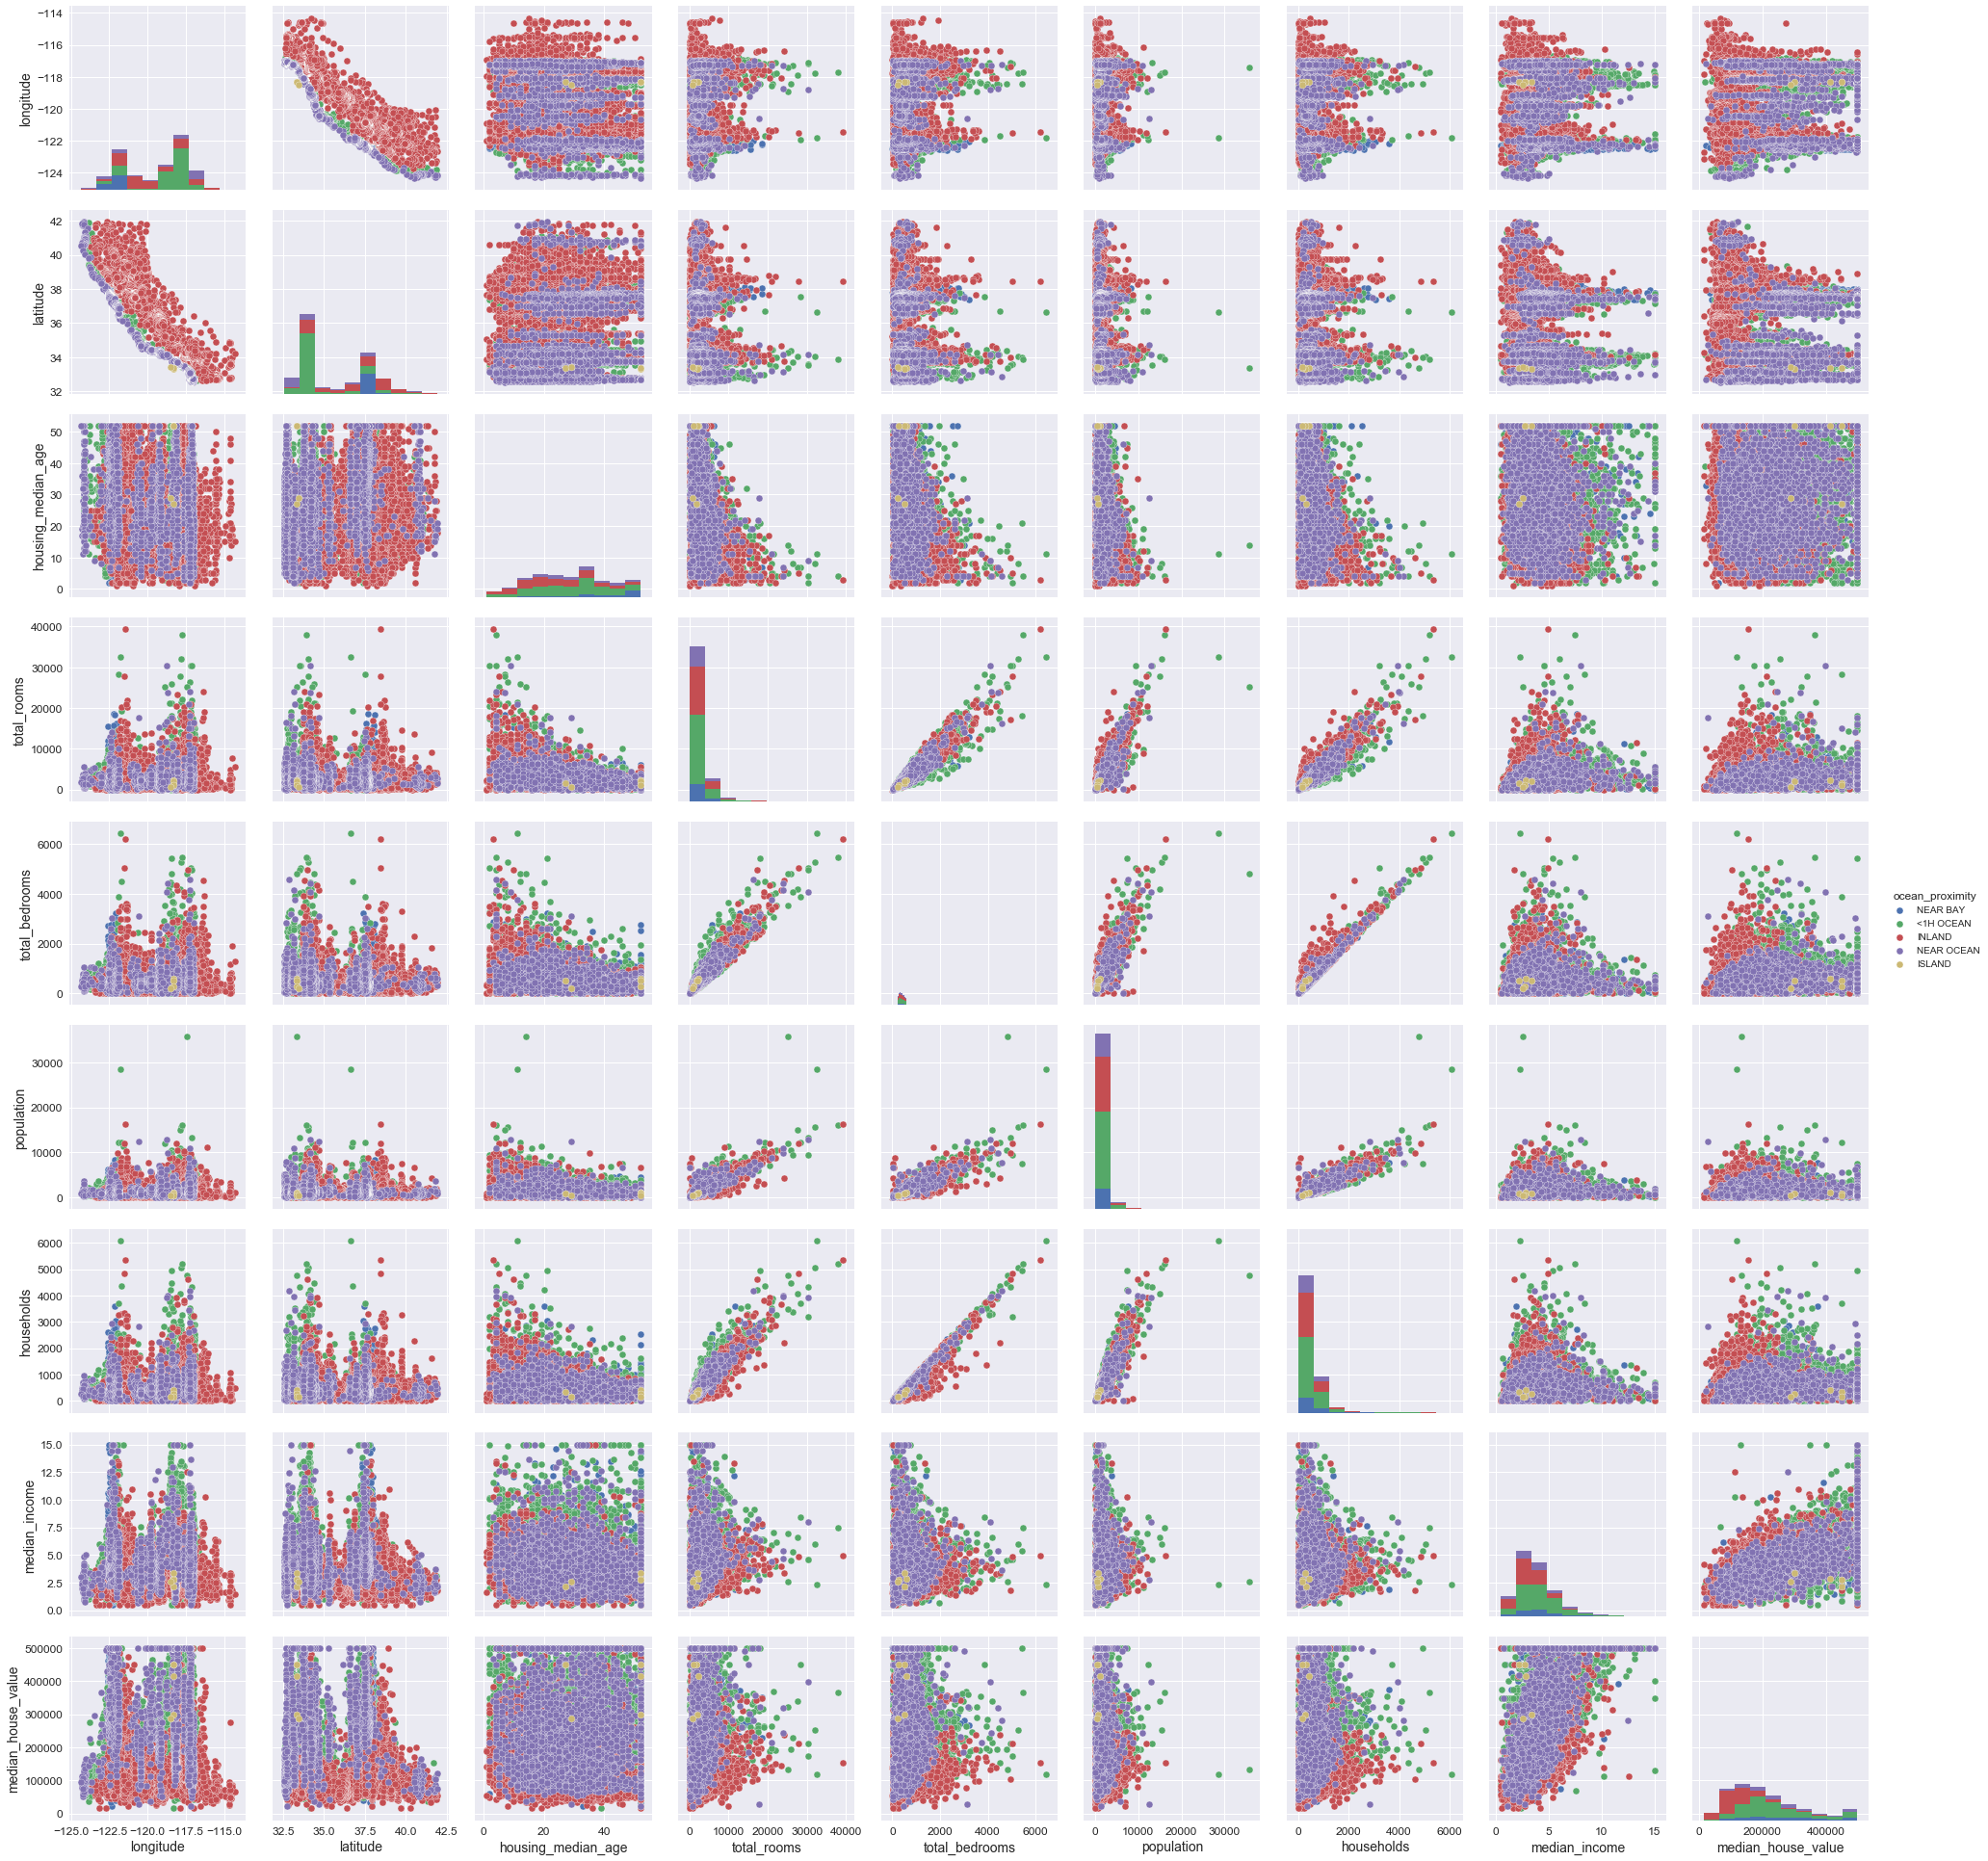

In [115]:
sns_plot = sns.pairplot(housing, hue="ocean_proximity", size=3)
sns_plot.savefig("pair_plot_.eps", format='eps', dpi=1000)

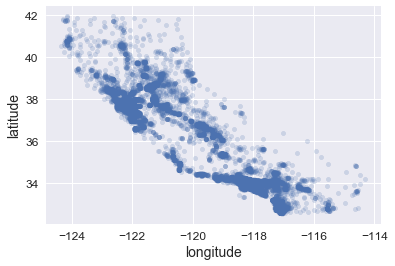

In [124]:
train_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2);

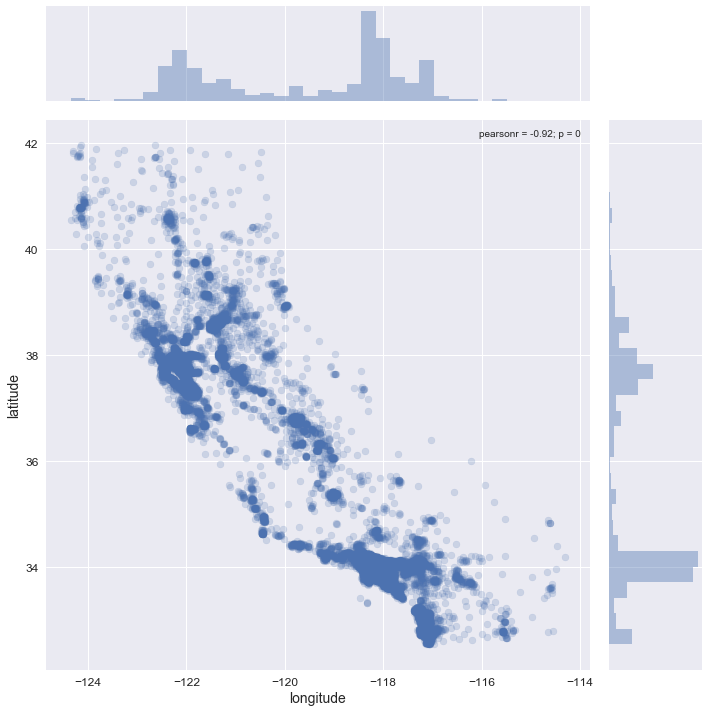

In [130]:
sns.jointplot(x="longitude", y="latitude", data=train_set, size=10, alpha=0.2);

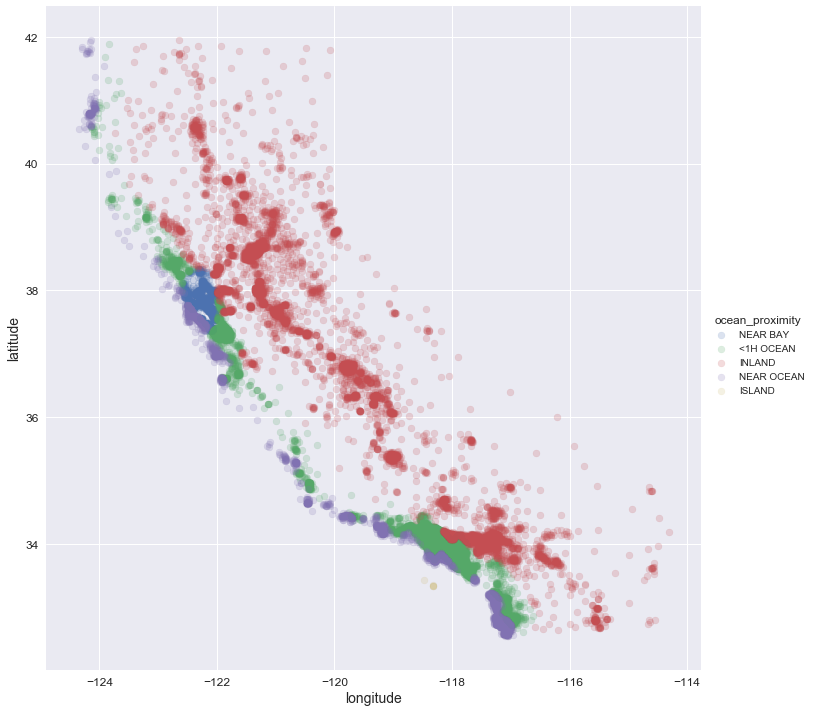

In [132]:
sns.FacetGrid(housing, hue="ocean_proximity", size=10).map(plt.scatter, "longitude", "latitude", alpha=0.2).add_legend();

In [154]:
train_set.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690647
rooms_per_household         0.158485
total_rooms                 0.133989
housing_median_age          0.103706
households                  0.063714
total_bedrooms              0.047980
population_per_household   -0.022030
population                 -0.026032
longitude                  -0.046349
bedrooms_per_household     -0.051351
latitude                   -0.142983
bedrooms_per_room          -0.257419
Name: median_house_value, dtype: float64

In [155]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
bedrooms_per_household     -0.046739
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

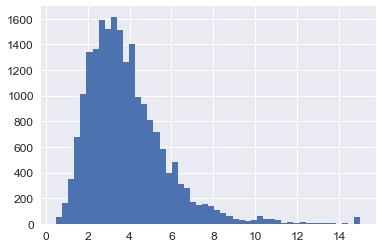

In [164]:
housing['median_income'].hist(bins=50)